In [1]:
import findspark
findspark.init('C:\opt\spark') 
# import necessary packages
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
sc = SparkContext()
# we initiate the StreamingContext with 10 second batch interval. #next we initiate our sqlcontext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [3]:

# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)
# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
lines = socket_stream.window(20) #dstreamvariable

In [4]:
from collections import namedtuple

fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )

fields2 = ("text", "count")
Sentiment = namedtuple('Sentiment', fields2)


In [5]:
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( "\n" ) ) #Splits to a list containing of the single tweets 
  .map( lambda word: ( word, 1) ) 
  .map( lambda rec: Sentiment( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
  .limit(100).registerTempTable("sentiment") ) )
    #  hier: alle texte müssen raus und schleife braucht viel zu lange...

In [6]:
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  # Checks for    hashtag calls  
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
 # Stores in a Tweet Object
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 # Registers only top 10 hashtags to a table.
  .limit(10).registerTempTable("tweets") ) )

In [7]:

  # start streaming and wait couple of minutes to get enought tweets
ssc.start()


In [8]:

# import libraries to visualize the results
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from textblob import TextBlob


In [9]:
time.sleep(30)

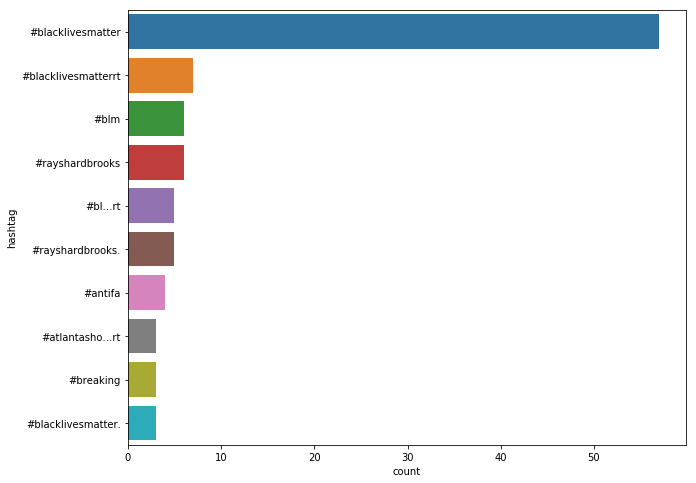

Sentiment(polarity=0.0, subjectivity=0.0)
0.0
I am shook. #blacklivesmatternz 
0
1
Sentiment(polarity=0.12962962962962965, subjectivity=0.20370370370370372)
0.12962962962962965
Police station support for people arrested #BlackLivesMatter is needed now (morning 14/06). Can you…RT @ProudSocialist: If you’re more upset about a Wendy’s being burnt to the ground than a black man being murdered by the police then you c…RT @mamaneshow: Voilà. C'est ce Colbert là que certains défendent. La VAR de l'Histoire regarde les menteurs. #BlackLivesMatterRT @milkatabout: 感染拡大RT @mefeater: #RayshardBrooks was shot and killed by two Atlanta Police officers last night. He was shot in the back as he was running away…RT @patfrank: I recognize that no one wants to hear from a white guy who lives in the suburbs, so I did what I do best: I made a video and…RT @ChalecosAmarill: 🎥🛑En #EEUU la oficina de investigación de Georgia pública el video DE LA EJECUCIÓN de #RayshardBrooks ASESINADO a tiro…RT @HackneyAbbot

In [10]:
#matplotlib inline
count = 0
sen = list(range(100))
while count < 1:
    
    time.sleep(5)
    # top hashtags:
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    #sentiment analysis:
    top_10_senti = sqlContext.sql( 'Select text from sentiment' )
    top_10_s = top_10_senti.toPandas()
   # print(top_10_s)

    # Schleife über alle texte, die in top_10_s gespeichert sind, und davon jeweils die sentiment analysis
    n = 99
    s = 0
    i = 1
    while i <= n:
        opinion = TextBlob(top_10_s["text"][i])
        print(opinion.sentiment)
        print(opinion.sentiment[0])
        print(top_10_s["text"][i])
        sen[i] = opinion.sentiment[0]
        print(s)
        print(i)
        s = s + i
        i = i + 1
        
    count = count + 1
    print(count)
    print(sen)

In [14]:
print(sen)

[0, 0.0, 0.0, 0.0, 0.0738095238095238, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6065340909090909, 0.0, 0.25, 0.0, 0.0, 0.0, -0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.20000000000000004, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [15]:
print(top_10_s)

                                                 text
0   🐥Ah Baby Bear is my nickname for Winter Bear@O...
1                                        -yoongi: D-2
2                                      -jin: epiphany
3                                 -hoseok: hope world
4   🐥Ah Baby Bear is my nickname for Winter BearRT...
..                                                ...
77  @BTS_twtRT @haruharu_w_bts: q: Song that comes...
78                                     a: winter bear
79                                                   
80  @BTS_twtRT @hobivmn: jimi keeps calling winter...
81                               💜No it’s Winter Bear

[82 rows x 1 columns]
